In [ ]:
!pip install -qU langchain_community langchain_anthropic langchain_experimental matplotlib langgraph

In [ ]:
import os

os.environ['ANTHROPIC_API_KEY'] = 'YOUR_ANTHROPIC_API_KEY'
os.environ['TAVILY_API_KEY'] = 'YOUR_TAVILY_API_KEY'

# Multi-Agent Network

A single agent can usually operate effectively using a handful of tools within a single domain.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a **multi-agent network** architecture.

# Define tools

In [11]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


tavily_tool = TavilySearchResults(max_reuslts=5)

# This executes code locally, which can be unsafe when not sandboxed
repl = PythonREPL()


@tool
def python_repl_tool(
        code: Annotated[str, "The python code to execute to generate your chart."],
):
    """use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL_ANSWER."
    )

# Create graph

Now we have defined tools and made some helper functions, we will create the individual agents below and tell them how to talk to each other using LangGraph.

## Define Agent Nodes

In [12]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools"
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [13]:
from langchain_core.messages import HumanMessage
from langchain_anthropic import ChatAnthropic

from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState

# LLM
llm = ChatAnthropic(model='claude-3-sonnet-20240229')

# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        'You can only do research. You are working with a chart generator colleague.'
    ),
)



def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    # Wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result['messages'][-1] = HumanMessage(
        content=result['messages'][-1].content,
        name='researcher',
    )

    return {
        # Share internal message history of research agent with other agents
        'messages': result['messages'],
    }

In [14]:
# Chart generator agent and node
# NOTE: This performs arbitrary code execution, which can be unsafe when not sandboxed
chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    state_modifier=make_system_prompt(
        "You can only generate charts. You are working with a researcher collegue."
    ),
)


def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)

    # Wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result['messages'][-1] = HumanMessage(
        content=result['messages'][-1].content,
        name='chart_generator',
    )

    return {
        # Share internal message history of chart agent with other agents
        'messages': result['messages'],
    }

## Define Edge Logic

We can define some of the edge logic that is needed to decide what to do based on results of the agents.

In [15]:
from langgraph.graph import START, END, StateGraph

def router(state: MessagesState):
    # This is a router
    messages = state['messages']
    last_message = messages[-1]

    if 'FINAL ANSWER' in last_message.content:
        # Any agent decided the work is DONE
        return END

    return 'continue'

## Define the Graph

In [16]:
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(MessagesState)

# add nodes
workflow.add_node('researcher', research_node)
workflow.add_node('chart_generator', chart_node)

# add edges
workflow.add_edge(START, 'researcher')
workflow.add_conditional_edges(
    'researcher',
    router,
    {
        'continue': 'chart_generator',
        END: END,
    }
)
workflow.add_conditional_edges(
    'chart_generator',
    router,
    {
        'continue': 'researcher',
        END: END,
    }
)

graph = workflow.compile()

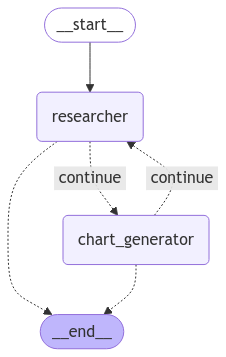

In [17]:
from IPython.display import Image, display

display(Image(
    graph.get_graph().draw_mermaid_png(),
))

# Invoke

In [18]:
events = graph.stream(
    {
        'messages': [
            (
                'user',
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {
        'recursion_limit': 150,
    }
)

for event in events:
    print(event)
    print('--------')

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='fea14198-46ea-4782-be22-2abbd5f1dd5a'), AIMessage(content=[{'id': 'toolu_01TPDYcAvTv75H8miFmkQmgB', 'input': {'query': 'uk gdp by year past 5 years'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01DyJBoqBFbfNCczxxGfd5yf', 'model': 'claude-3-sonnet-20240229', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 400, 'output_tokens': 67}}, id='run-5dbc8ed5-aa4e-4b53-a1bd-35c1ae6ee0c1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'uk gdp by year past 5 years'}, 'id': 'toolu_01TPDYcAvTv75H8miFmkQmgB', 'type': 'tool_call'}], usage_metadata={'input_tokens': 400, 'output_tokens': 67, 'total_tokens': 467, 'input_token_details': {}}), ToolMessage(content='[{"url": "https: